In [3]:
import numpy as np
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.util import add_cyclic_point
import copy
import xarray as xr

In [7]:
ds = xr.open_dataset("/glade/scratch/jinmuluo/archive/fanv3clm2000/lnd/hist/fanv3_debugging.clm2.h0.2000-05.nc")

In [8]:
def map_function(da, cb=0, cmap='viridis', panel=None,  ax=None, title=None, vmax=None, vmin=None, units=None,nbins=200):
    "a function to make one subplot"
    wrap_data, wrap_lon = add_cyclic_point(da.values, coord=da.lon)

    if ax is None: ax = plt.gca()

    # define the colormap, including the number of bins
    cmap = copy.copy(plt.get_cmap(cmap,nbins))
    im = ax.pcolormesh(wrap_lon,da.lat,wrap_data,transform=ccrs.PlateCarree(), vmax=vmax,vmin=vmin,cmap=cmap)

    # set the bounds of your plot
    ax.set_extent([-180,180,-90,90], crs=ccrs.PlateCarree())

    # add title & panel labels
    ax.set_title(title,loc='left', fontsize='large', fontweight='bold')
    ax.annotate(panel, xy=(0.05, 0.90), xycoords=ax.transAxes, ha='center', va='center',fontsize=16)    

    # add plotting features
    ax.coastlines()
    ocean = ax.add_feature(cfeature.NaturalEarthFeature('physical','ocean','110m', facecolor='white'))
    
    # control colorbars on each plot & their location
    if cb == 1:
        cbar = fig.colorbar(im, ax=ax,pad=0.02, fraction = 0.03, orientation='horizontal')
        cbar.set_label(units,size=12,fontweight='bold')
    if cb == 2:
        cbar = fig.colorbar(im, ax=ax,pad=0.02, fraction = 0.05, orientation='vertical')    
        cbar.set_label(units,size=12)#,weight='bold')
        

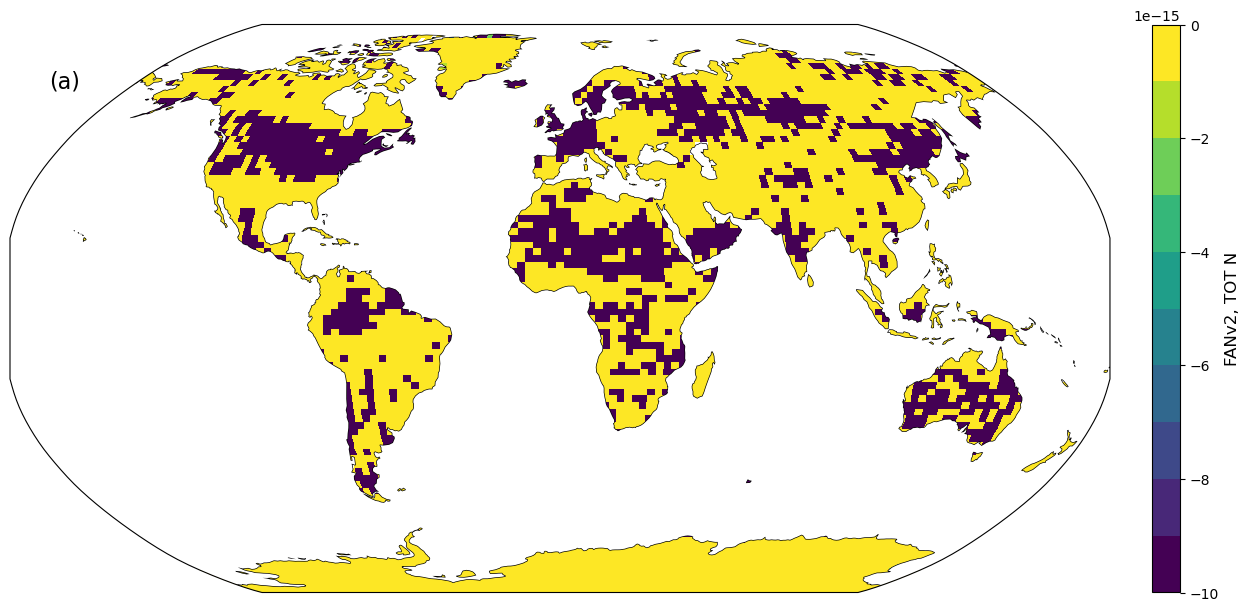

In [11]:
var="MANURE_NITRITE_TO_SOIL"
i = 0
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(13,6), constrained_layout=True, subplot_kw=dict(projection=ccrs.Robinson()))
for index, ax in np.ndenumerate(axes):
    if i == 0:
        plotData = ds[var].isel(time=0)
        map_function(plotData, ax=ax,cb=2, panel='(a)', nbins=10, vmax=0, vmin=-1e-14, units='FANv2, TOT N')  
                     
    i = i+1